# Teams Modeling

In [1]:
# import libraries 
import pandas as pd
import numpy as np
import math
from scipy.stats import kurtosis, skew

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import r2_score, mean_squared_error

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler, MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline

# this will allow us to visualize the pipeline (may not be available in learn-env)
from sklearn import set_config
set_config(display= 'diagram')

from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, \
RandomizedSearchCV, StratifiedKFold, KFold
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, \
AdaBoostClassifier, GradientBoostingClassifier

from pickle import dump, load

# ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)

np.random_state = 42

In [9]:
# load batting_basic
bb_teams = pd.read_csv('Data/team_batting_basic', index_col = 0)
bb_teams = bb_teams.drop(columns = ['name', 'L', 'Season', 'Team', 'Age', 'G'])
bb_teams.head()

,attendance,W,AB,PA,H,1B,2B,3B,HR,R,RBI,BB,IBB,SO,HBP,SF,SH,GDP,SB,CS,AVG,BB%,K%,BB/K,OBP,SLG,OPS,ISO,BABIP
0,1187849.0,89,5170.0,5911.0,1307.0,945.0,206.0,33.0,123.0,682.0,640.0,596.0,36.0,800.0,36.0,37.0,72.0,127.0,37.0,24.0,0.253,0.101,0.135,0.75,0.332,0.377,0.709,0.124,0.276
1,1129866.0,65,5215.0,5931.0,1359.0,969.0,234.0,32.0,124.0,658.0,623.0,570.0,33.0,799.0,25.0,51.0,70.0,153.0,34.0,28.0,0.261,0.096,0.135,0.71,0.333,0.389,0.722,0.128,0.284
2,1644460.0,87,5191.0,5966.0,1402.0,1010.0,242.0,38.0,112.0,741.0,684.0,567.0,36.0,648.0,54.0,59.0,95.0,133.0,122.0,48.0,0.270,0.095,0.109,0.88,0.345,0.396,0.741,0.126,0.287
3,809770.0,60,5311.0,5960.0,1293.0,913.0,213.0,48.0,119.0,634.0,600.0,531.0,69.0,897.0,19.0,35.0,64.0,109.0,51.0,34.0,0.243,0.089,0.151,0.59,0.313,0.369,0.681,0.125,0.271
4,663486.0,67,5289.0,5940.0,1324.0,914.0,230.0,40.0,140.0,640.0,604.0,512.0,44.0,858.0,34.0,45.0,60.0,110.0,73.0,37.0,0.250,0.086,0.144,0.60,0.318,0.388,0.706,0.138,0.273


## Checking Correlations Between Features

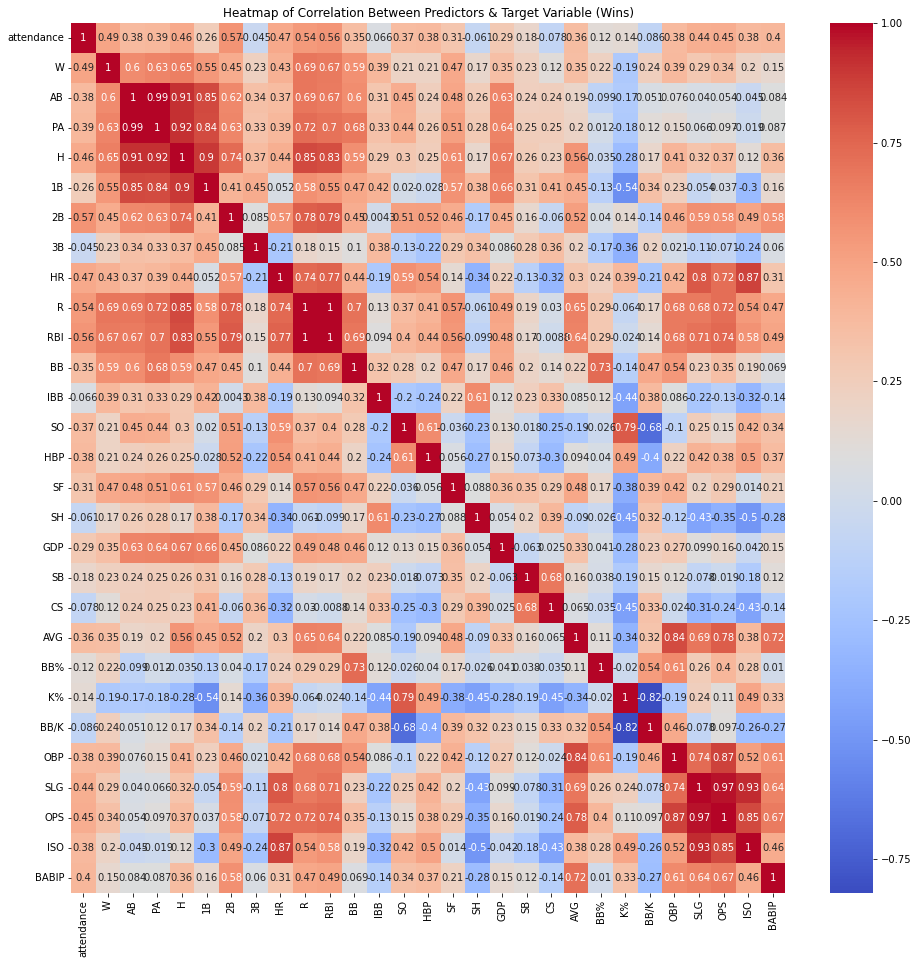

In [10]:
# set up figure size
fig, ax = plt.subplots(figsize=(16, 16))

# set up correlation matrix
corr = bb_teams.corr()

sns.heatmap(corr, cmap = 'coolwarm', annot = True)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Predictors & Target Variable (Wins)");

plt.show()

## Feature Selection

**Multicollinearity**

In [358]:
corr_df = batting_basic.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
corr_df['pairs'] = list(zip(corr_df.level_0, corr_df.level_1))

# set index to pairs
corr_df.set_index(['pairs'], inplace = True)

#drop level columns
corr_df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
corr_df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
corr_df.drop_duplicates(inplace=True)

In [359]:
corr_df[(corr_df.cc>0.9) & (corr_df.cc <1)]

,cc
pairs,
"(PA, AB)",0.996289
"(Adjusted 2021 Salary, Salary)",0.989199
"(H, AB)",0.975935
"(PA, H)",0.972980
"(SLG, OPS)",0.965462
"(H, 1B)",0.963932
"(R, H)",0.937833
"(PA, G)",0.937455
"(PA, R)",0.936717
